# Importar llibreries

Importem les diferents llibreries i mètodes corresponents que ens permetran realitzar l'estudi. Com a novetat, farem servir la llibreria Tensorflow mitjançant la qual és possible realitzar tasques d'aprenentatge automàtic. 

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from numpy import argmax

# Càrrega de dades

Carreguem fitxers de dades que ja han estat modificats i, en el nostre cas, balancejats en entregues anteriors. Es diferencien dos arxius: train i test. Cal notar que, evidentment, només el dataset de train ha estat balancejat. El balanceig s'ha dut a terme mitjançant tècniques d'interpolació aplicant el mètode Smote.

In [ ]:
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
dt_train_balanced = pd.read_csv('/content/drive/My Drive/TREBALL_IAAE/Jordi_Marc/dataset_apoplexia_SMOTE_train.csv',index_col=0)
dt_test = pd.read_csv('/content/drive/My Drive/TREBALL_IAAE/Jordi_Marc/dataset_apoplexia_testing.csv',index_col=0)

In [ ]:
dt_train_balanced.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,0.108016,0.0,0.0,1.0,0.0,0.307500,0.096220,0,0,0,0,1,1,0,0,0,No
1,1,0.401271,0.0,0.0,0.0,0.0,0.008683,0.261168,0,0,1,0,0,0,0,1,0,No
2,1,0.327957,0.0,0.0,1.0,0.0,0.222289,0.203895,0,0,1,0,0,0,1,0,0,No
3,1,0.608993,1.0,0.0,0.0,0.0,0.518151,0.235968,0,0,0,1,0,0,0,1,0,Yes
4,1,0.352395,0.0,0.0,0.0,0.0,0.216377,0.246277,0,0,1,0,0,0,0,1,0,No


In [ ]:
dt_train_balanced['stroke'].value_counts()

No     3403
Yes    3403
Name: stroke, dtype: int64

In [ ]:
dt_test['stroke'].value_counts()

No     1458
Yes      75
Name: stroke, dtype: int64

# Data 2 tensorflow

Separem els atributs de les classes tant a l'arxiu train com de test. 

In [ ]:
x_train = dt_train_balanced.iloc[:,:-1]
y_train = dt_train_balanced.iloc[:,-1]
x_test = dt_test.iloc[:,:-1]
y_test = dt_test.iloc[:,-1]

Comprovem que quadrin i tinguin les mateixes dimensions.

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6806, 17), (6806,), (1533, 17), (1533,))

Substituim els valors alfabètics 'Yes' i 'No' pels numèrics binars 1 i 0, respectivament.

In [ ]:
id = dt_train_balanced['stroke'].unique()
d = {p[1]:p[0] for p in enumerate(id)}
d

{'No': 0, 'Yes': 1}

In [ ]:
y_train = y_train.replace(d)

In [ ]:
id = dt_test['stroke'].unique()
d = {p[1]:p[0] for p in enumerate(id)}
d

{'No': 0, 'Yes': 1}

In [ ]:
y_test = y_test.replace(d)

# Disseny de la xarxa neuronal

A continuació es dissenya la xarxa neuronal.

Aquesta està formada per només una capa d'entrada i una de sortida. Això és perquè si no el model queda Overfitted, és a dir, ha aprés molt del dataset train però presenta resultats pobres enfront dades de validació o que mai ha vist anteriorment.

Per evitar-ho, s'ha seguit el següent procés:

*   1) Iniciem amb un model de poca complexitat, poques capes i neurones
*   2) Aumentem la complexitat del model (mitjançant l'ampliació d'epochs, capes, neurones, etc.) progressivament, fins observar senyals d'Overfitted. En altres paraules, forcem l'Overfitting.
*   3) Disminuim la complexitat del model (reduint el nombre d'epochs, capes, neurones..) fins arribar al punt òptim on el model és el més compacte i fiable possible.

En el nostre cas tenim una capa d'entrada formada per 20 neurones i una capa de sortida formada per una única neurona -ja que la nostra classe es binària-. És la configuració que ha donat millors resultats. Les funcions d'activació emprades han estat relu i sigmoid.


In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                360       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 105       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 471
Trainable params: 471
Non-trainable params: 0
_________________________________________________________________


# Training

Hem definit pel train un total de 150 epochs i un batch size de 128.

In [ ]:
epochs=500
batch_size=32

In [ ]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/500
171/171 [==============================] - 3s 7ms/step - loss: 0.6562 - accuracy: 0.5957 - val_loss: 0.8383 - val_accuracy: 0.1395
Epoch 2/500
171/171 [==============================] - 1s 5ms/step - loss: 0.5719 - accuracy: 0.6835 - val_loss: 0.7456 - val_accuracy: 0.4978
Epoch 3/500
171/171 [==============================] - 1s 5ms/step - loss: 0.5391 - accuracy: 0.7028 - val_loss: 0.6736 - val_accuracy: 0.6689
Epoch 4/500
171/171 [==============================] - 1s 5ms/step - loss: 0.5142 - accuracy: 0.7261 - val_loss: 0.6635 - val_accuracy: 0.6909
Epoch 5/500
171/171 [==============================] - 1s 5ms/step - loss: 0.5021 - accuracy: 0.7320 - val_loss: 0.6427 - val_accuracy: 0.7247
Epoch 6/500
171/171 [==============================] - 1s 4ms/step - loss: 0.4880 - accuracy: 0.7423 - val_loss: 0.5852 - val_accuracy: 0.7797
Epoch 7/500
171/171 [==============================] - 1s 5ms/step - loss: 0.4854 - accuracy: 0.7502 - val_loss: 0.6068 - val_accuracy: 0.7643

# Evaluation

Obtenim un accuracy del 82,3%. Cal recordar que tractem amb un dataset de medicina el qual suposa que hem de tractar amb especial cura els falsos positius. 

Per tant, a part del valor d'accuracy, s'ha tingut molt en compte aquest factor el qual pren un valor trascendental. El total de falsos positius és de 32 suposant un 2,6% del total de prediccions negatives.

In [ ]:
model.evaluate(x_test, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.8141


[0.4461189806461334, 0.8140900135040283]

In [ ]:
preds = pd.Series(['Yes' if x>0.5 else 'No' for x in model.predict(x_test).T[0]],name='preds')
reals = pd.Series(dt_test.iloc[:,-1],name='reals')
reals.index=preds.index

In [ ]:
accuracy_score(reals,preds)

0.8140900195694716

In [ ]:
pd.crosstab(reals,preds)

preds,No,Yes
reals,,
No,1213,245
Yes,40,35


# Plots

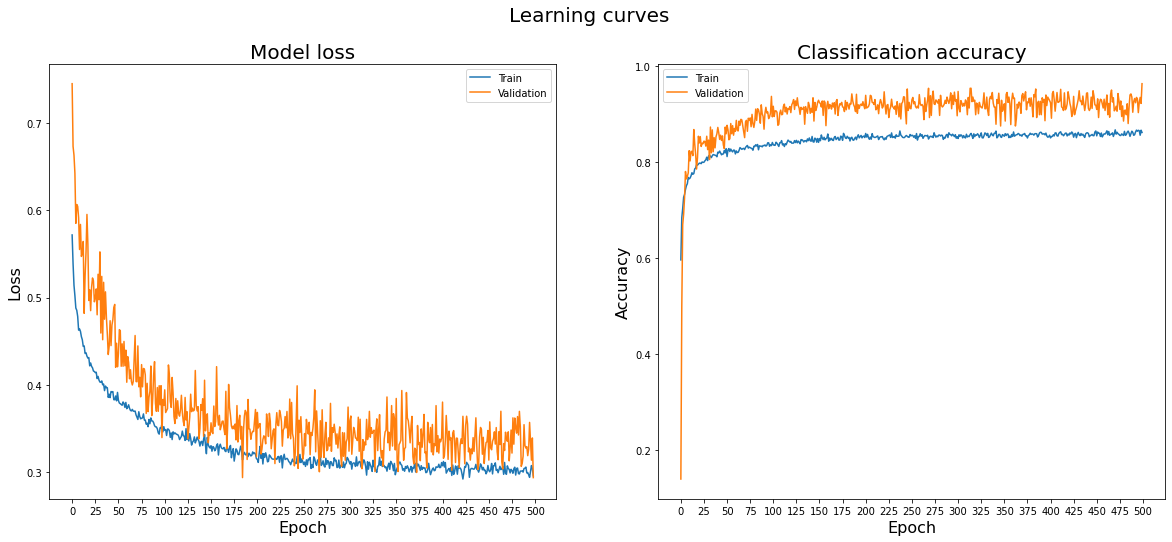

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'][1:])
ax1.plot(history.history['val_loss'][1:])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, epochs+1, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, epochs+1, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()